In [1]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

In [2]:
if IS_COLAB:
    !git clone https://github.com/wpan03/quick_ds_python.git
    %cd quick_ds_python
    !pip install treeinterpreter==0.2.3
    !pip install scikit-learn==0.24.1
    !pip install tune-sklearn ray[tune]
    !pip install lime==0.2.0
    !pip install pandas_profiling==3.0.0
else:
    %load_ext autoreload
    %autoreload 2

In [3]:
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import pandas as pd
from pandas_profiling import ProfileReport
from ray.tune.sklearn import TuneSearchCV
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

from src.eda import get_freq_table, plot_corr_heatmap, see_missing
from src.evaluate import binary_cross_evaluate, binary_evaluation
from src.explain import (
    get_binary_error_analysis,
    get_feature_imp,
    get_permute_imp_df,
    plot_permute_imp,
    plot_single_instance_explaination,
)
from src.model_supervised import find_dt_clf_max_depth
from src.preprocess import do_transform, get_preprocessor, get_x_y


In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/wpan03/quick_ds_python/master/data/titanic_train.csv')

## EDA

In [5]:
profile = ProfileReport(df, title="Pandas Profiling Report")

In [6]:
profile.to_notebook_iframe()

Render HTML: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


In [7]:
df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [8]:
df.shape

(891, 12)

In [9]:
see_missing(df, only_missing=True)

columns  total_missing  percent_missing
0     Cabin            687        77.104377
1       Age            177        19.865320
2  Embarked              2         0.224467

In [10]:
plot_corr_heatmap(df)

In [11]:
get_freq_table(df, 'Survived')

count  percentage
0    549    0.616162
1    342    0.383838

In [12]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [13]:
model_vars = ['Pclass', 'Sex', 'Age', 'Fare', 'Survived']

## Preprocess

### Train and Test Split

In [14]:
df_mod = df[model_vars]

In [15]:
X, y = get_x_y(df_mod, label_col='Survived')

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=36)

### Encode and Impute

In [17]:
oh_enc = preprocessing.OneHotEncoder(drop='if_binary')
med_imp = SimpleImputer(strategy='median')

In [18]:
preprocessor = get_preprocessor(cat_pipeline=oh_enc, num_pipeline=med_imp)
preprocessor

ColumnTransformer(transformers=[('onehotencoder',
                                 OneHotEncoder(drop='if_binary'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fed432941c0>),
                                ('simpleimputer',
                                 SimpleImputer(strategy='median'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fed43294490>)])

In [19]:
_ = preprocessor.fit(X)

In [20]:
col_names = list(preprocessor.transformers_[0][1].get_feature_names()) + preprocessor.transformers_[1][2]
col_names

['x0_male', 'Pclass', 'Age', 'Fare']

In [21]:
X_train_prepared = do_transform(X_train, preprocessor, col_names)
X_test_prepared = do_transform(X_test, preprocessor, col_names)

## Fit Model

In [22]:
mod_rf = RandomForestClassifier(random_state=36)

In [23]:
_ = mod_rf.fit(X_train_prepared, y_train)

In [24]:
binary_evaluation(X_train_prepared, y_train, mod_rf)

metrics     value
0      accuracy  0.979042
1  balanced acc  0.975351
2     precision  0.983740
3        recall  0.960317
4            f1  0.971888

In [25]:
binary_cross_evaluate(X_train_prepared, y_train, mod_rf)

fit_time  score_time  test_accuracy   test_f1
0  0.119477    0.010838       0.820628  0.759036
1  0.105427    0.010649       0.807175  0.732919
2  0.102727    0.010349       0.756757  0.662500

## Hyperparameter Tuning

In [26]:
rf_grids = {'max_features': ['auto', 'sqrt', 0.5],
            'min_samples_leaf': [1, 3, 5, 7, 9],
            'n_estimators': [50, 100, 200, 400]}

In [27]:
%%time
tune_search = TuneSearchCV(RandomForestClassifier(), rf_grids, cv=3,
                           n_trials=20, n_jobs=-1,
                           random_state=36, search_optimization='hyperopt')
_ = tune_search.fit(X_train_prepared, y_train)


CPU times: user 883 ms, sys: 284 ms, total: 1.17 s
Wall time: 8.79 s


In [28]:
df_cv_result = pd.DataFrame(tune_search.cv_results_)
df_cv_result.loc[:, ~df_cv_result.columns.str.startswith("split")].drop(
    ["params"], axis=1
).sort_values("rank_test_score", ignore_index=True).head()



mean_test_score  std_test_score  rank_test_score  time_total_s  \
0         0.812804        0.045551                1      0.424082   
1         0.811296        0.044383                2      1.486395   
2         0.805323        0.035245                3      2.309373   
3         0.805317        0.042848                4      0.409465   
4         0.805317        0.040763                4      0.376073   

   training_iteration param_max_features param_min_samples_leaf  \
0                   1                0.5                      5   
1                   1               sqrt                      5   
2                   1               sqrt                      7   
3                   1               auto                      5   
4                   1               sqrt                      5   

  param_n_estimators  
0                 50  
1                200  
2                400  
3                 50  
4                 50

In [29]:
tune_search.best_params_

{'max_features': 0.5, 'min_samples_leaf': 5, 'n_estimators': 50}

In [30]:
tune_search.best_score_

0.8128038352253598

In [31]:
mod_rf_final = tune_search.best_estimator_

In [32]:
binary_cross_evaluate(X_train_prepared, y_train, mod_rf_final)

fit_time  score_time  test_accuracy   test_f1
0  0.060683    0.007013       0.856502  0.786667
1  0.051130    0.006455       0.807175  0.726115
2  0.052782    0.006850       0.756757  0.662500

## Error Analysis

In [33]:
get_binary_error_analysis(X_test_prepared, y_test, mod_rf_final, only_show_error=True).head(5)

x0_male  Pclass   Age    Fare  class1_prob  pred_class  actual_class  \
0      0.0     1.0   2.0  151.55     0.999615           1             0   
1      0.0     1.0  25.0  151.55     0.997393           1             0   
2      0.0     2.0  26.0   26.00     0.981955           1             0   
3      1.0     2.0  62.0   10.50     0.022180           0             1   
4      0.0     2.0  44.0   26.00     0.945116           1             0   

       loss  
0  7.863267  
1  5.949617  
2  4.014911  
3  3.808582  
4  2.902526

## Explain the Model

### Random Forest Feature Importance

In [34]:
get_feature_imp(X_train_prepared, mod_rf_final)

name     score
0  x0_male  0.395428
1     Fare  0.266290
2      Age  0.195266
3   Pclass  0.143016

### Permutation Feature Importance

Learn more about it [here](https://scikit-learn.org/stable/modules/permutation_importance.html).

In [35]:
df_permute, permute_result = get_permute_imp_df(mod_rf_final, X_test_prepared, y_test, return_full_result=True)

In [36]:
df_permute

name  importance_mean  importance_std
0  x0_male         0.221525        0.012232
1   Pclass         0.102242        0.016391
2      Age         0.032287        0.014294
3     Fare         0.025112        0.009234

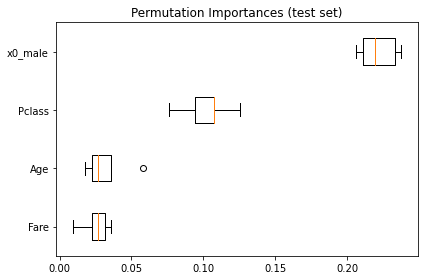

In [37]:
plot_permute_imp(X_test_prepared, permute_result)

### Surrogate Tree

See [here](https://christophm.github.io/interpretable-ml-book/global.html) for the idea behind surrogate tree.

In [38]:
y_train_surr = mod_rf_final.predict(X_train_prepared)

In [39]:
cv_dt_acc = find_dt_clf_max_depth(X_train_prepared, y_train, max_depth_range=range(1, 20))
cv_dt_acc

array([0.77688226, 0.77538076, 0.80083896, 0.8127971 , 0.78734564,
       0.79482622, 0.78589801, 0.77388599, 0.78136657, 0.78138677,
       0.77390619, 0.76938822, 0.75743681, 0.76193458, 0.75893158,
       0.75594204, 0.75294577, 0.75294577, 0.75294577])

In [40]:
mod_dt_surr = DecisionTreeClassifier(max_depth=3).fit(X_train_prepared, y_train_surr)

In [41]:
mod_dt_surr

DecisionTreeClassifier(max_depth=3)

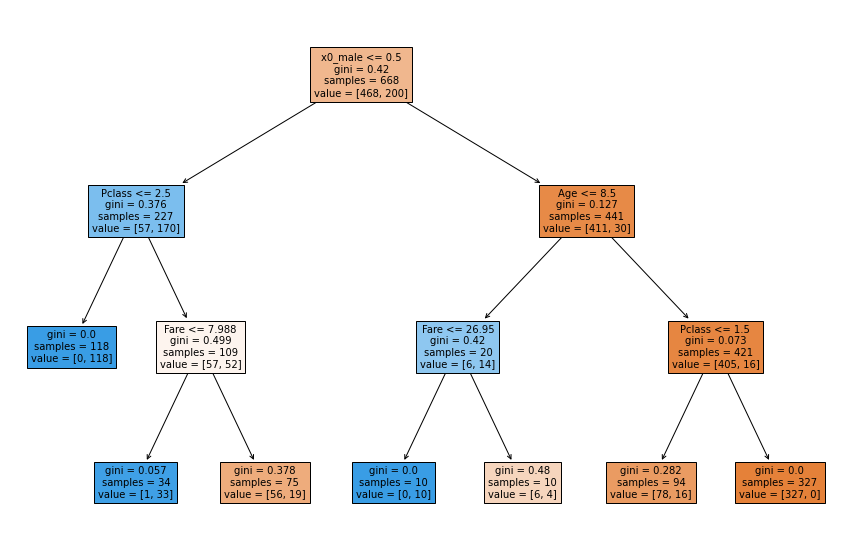

In [42]:
fig = plt.figure(figsize=(15, 10))
_ = plot_tree(mod_dt_surr, feature_names=X_test_prepared.columns, filled=True, fontsize=10)

### Tree Interpreter

See the [package repo](https://github.com/andosa/treeinterpreter).

In [43]:
instance = X_test_prepared.iloc[[18], :]
instance

x0_male  Pclass   Age  Fare
18      1.0     1.0  61.0  33.5

In [44]:
plot_single_instance_explaination(mod_rf_final, instance)

### LIME

In [45]:
instance

x0_male  Pclass   Age  Fare
18      1.0     1.0  61.0  33.5

In [46]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_prepared.values,
    mode="classification",
    feature_names=list(X_train_prepared.columns),
    discretize_continuous=True,
)

exp = explainer.explain_instance(instance.values[0], mod_rf_final.predict_proba, num_features=4)

In [47]:
exp.show_in_notebook(show_table=True, show_all=True)